In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
# Importing data
df = pd.read_csv('data.csv', encoding='latin')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### Exploratory data analysis

#### Quick statistical overview

In [3]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


We see negative quantities and prices, we can see that not all records have CustomerID data, we can also see that the majority of transactions are for quantites from 3 to 10 items, majority of items have price up to 5 pounds and that we have a bunch of huge outliers we will have to deal with later.

Dealing with types

In [4]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [5]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df.set_index('InvoiceDate')

#### Dealing with null values

In [6]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
df = df.drop(columns=['CustomerID'])

In [8]:
df[df['Description'].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country
InvoiceDate,,,,,,
2010-12-01 11:52:00,536414,22139,NaN,56,0.0,United Kingdom
2010-12-01 14:32:00,536545,21134,NaN,1,0.0,United Kingdom
2010-12-01 14:33:00,536546,22145,NaN,1,0.0,United Kingdom
2010-12-01 14:33:00,536547,37509,NaN,1,0.0,United Kingdom
2010-12-01 14:34:00,536549,85226A,NaN,1,0.0,United Kingdom


The data in these rows is pretty strange as UnitPrice is 0, so these orders do not generate any sales.
I think, we can impute it with "UNKNOWN ITEM" at the moment and deal with those later during the analysis.

In [9]:
df['Description'] = df['Description'].fillna('UNKNOWN ITEM')
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
UnitPrice      0
Country        0
dtype: int64

#### Checking out columns separately

In [10]:
df['Description'].value_counts().head()

WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED RETROSPOT               1638
Name: Description, dtype: int64

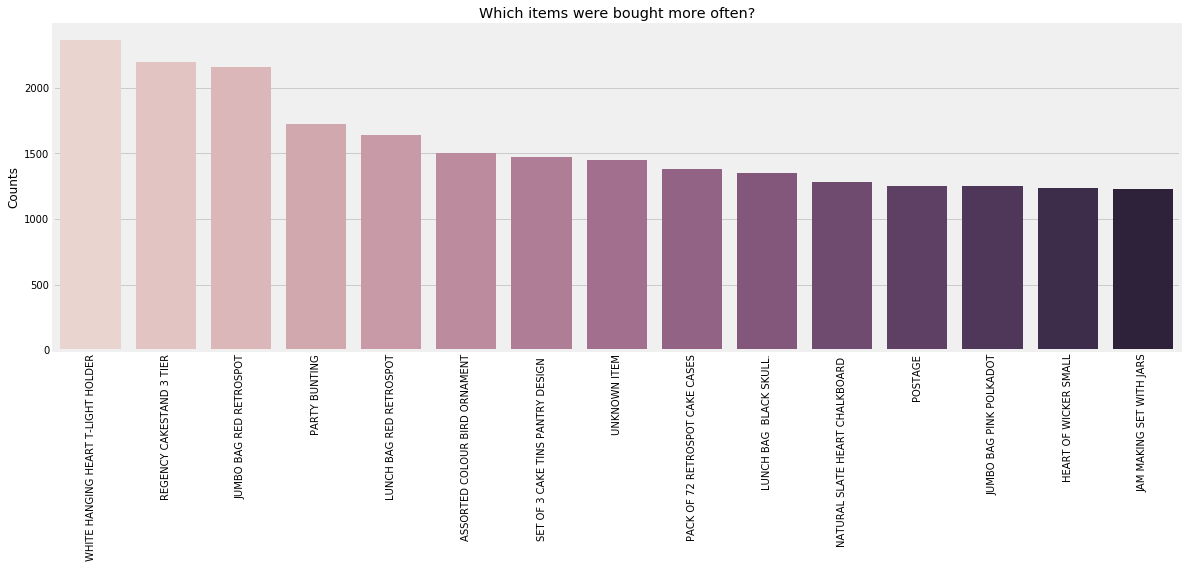

In [11]:
item_counts = df['Description'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(item_counts.index, item_counts.values, palette=sns.cubehelix_palette(15))
plt.ylabel("Counts")
plt.title("Which items were bought more often?");
plt.xticks(rotation=90);

In [12]:
df['Description'].value_counts().tail()

Lighthouse Trading zero invc incorr    1
?sold as sets?                         1
PINK BAROQUE FLOCK CANDLE HOLDER       1
FRYING PAN RED POLKADOT                1
PURPLE CHUNKY GLASS+BEAD NECKLACE      1
Name: Description, dtype: int64

We also notice from above code that valid items are normally uppercased and non-valid or cancelations are in lower case

In [13]:
df[~df['Description'].str.isupper()]['Description'].value_counts().head()

Manual                                572
BAG 125g SWIRLY MARBLES               304
BAG 250g SWIRLY MARBLES               252
3 TRADITIONAl BISCUIT CUTTERS  SET    240
POLYESTER FILLER PAD 40x40cm          193
Name: Description, dtype: int64

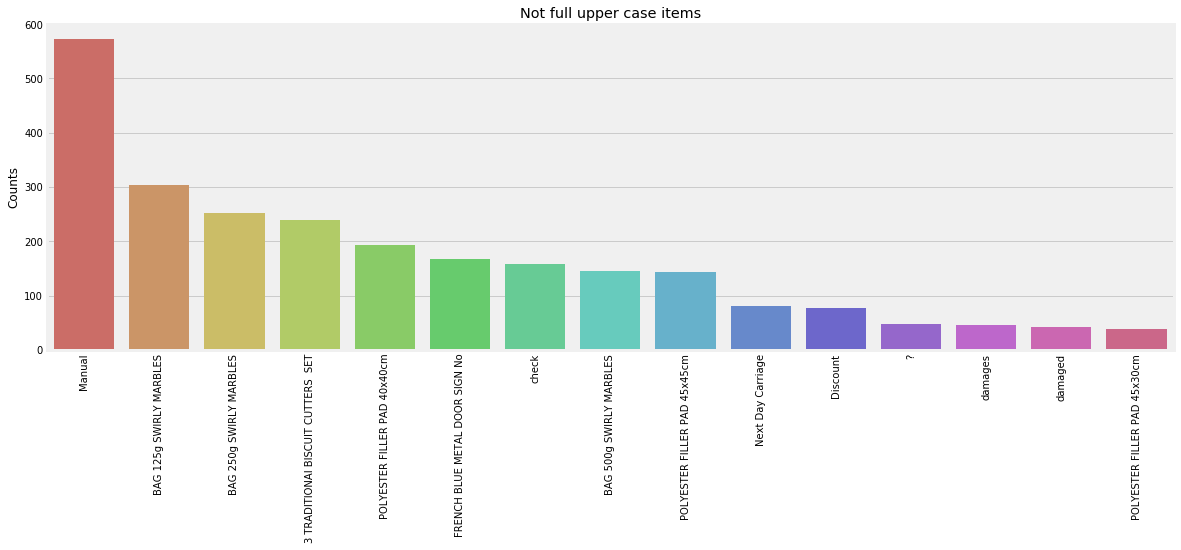

In [14]:
lcase_counts = df[~df['Description'].str.isupper()]['Description'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(lcase_counts.index, lcase_counts.values, palette=sns.color_palette("hls", 15))
plt.ylabel("Counts")
plt.title("Not full upper case items");
plt.xticks(rotation=90);

In [15]:
df['StockCode'].value_counts().head()

85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
Name: StockCode, dtype: int64

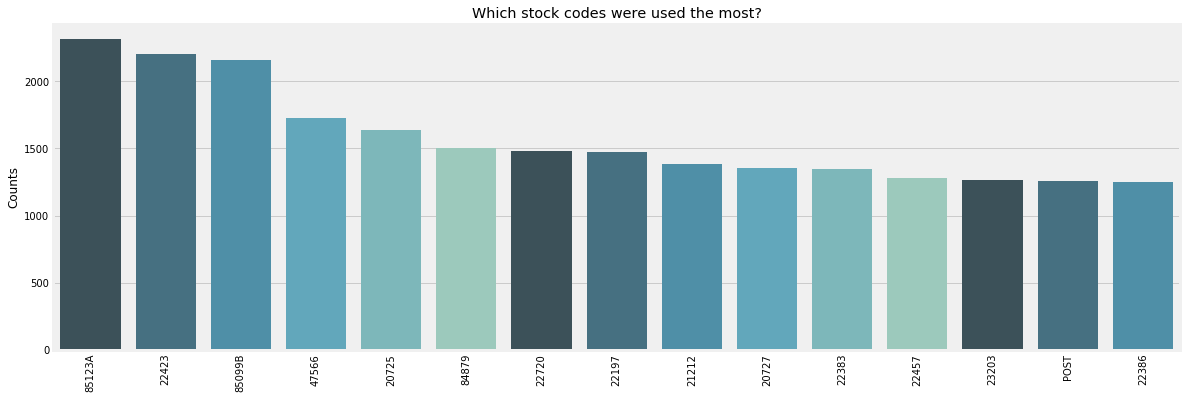

In [16]:
stock_counts = df['StockCode'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(stock_counts.index, stock_counts.values, palette=sns.color_palette("GnBu_d"))
plt.ylabel("Counts")
plt.title("Which stock codes were used the most?");
plt.xticks(rotation=90);

Checking out InvoiceNo feature.

In [17]:
df['InvoiceNo'].value_counts().tail()

C542924    1
561082     1
C566945    1
572656     1
538131     1
Name: InvoiceNo, dtype: int64

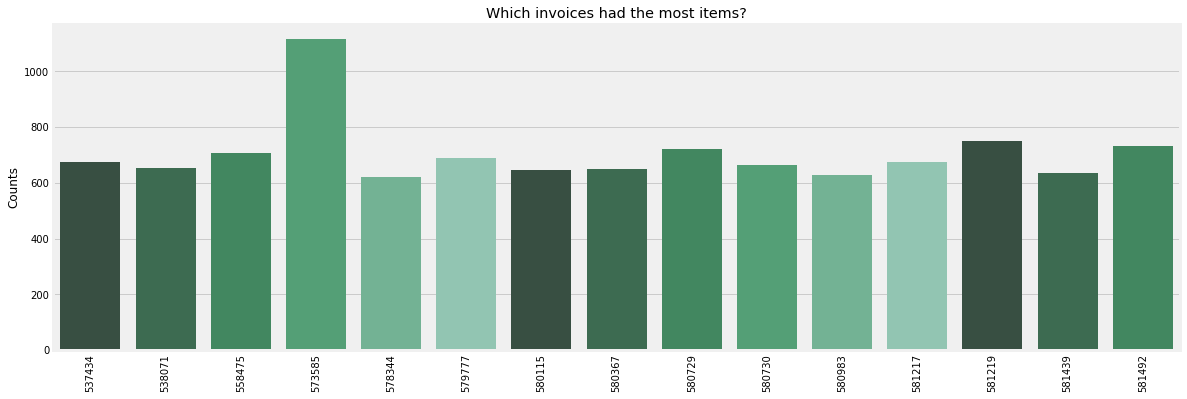

In [18]:
inv_counts = df['InvoiceNo'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(inv_counts.index, inv_counts.values, palette=sns.color_palette("BuGn_d"))
plt.ylabel("Counts")
plt.title("Which invoices had the most items?");
plt.xticks(rotation=90);

In [19]:
df[df['InvoiceNo'].str.startswith('C')].describe()

,Quantity,UnitPrice
count,9288.000000,9288.000000
mean,-29.885228,48.393661
std,1145.786965,666.600430
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,5.950000
max,-1.000000,38970.000000


Looks like Invoices that start with 'C' are the "Canceling"/"Returning" invoices. This resolves the mistery with negative quantities.

Although, we should've gotten deeper into analysis of those returns, for the sake of simplicity let's just ignore those values for the moment.

We can actually start a separate project based on that data and predict the returning/cancelling rates for the store.

In [20]:
# df[df['Quantity'] < 0]
df[df['Quantity'] < 0].head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country
InvoiceDate,,,,,,
2010-12-01 09:41:00,C536379,D,Discount,-1,27.50,United Kingdom
2010-12-01 09:49:00,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,4.65,United Kingdom
2010-12-01 10:24:00,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,1.65,United Kingdom
2010-12-01 10:24:00,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,0.29,United Kingdom
2010-12-01 10:24:00,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,0.29,United Kingdom


In [21]:
df = df[df['Quantity'] > 0]
df.describe()

,Quantity,UnitPrice
count,531285.000000,531285.000000
mean,10.655262,3.857296
std,156.830323,41.810047
min,1.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,13541.330000


We also see negative UnitPrice, which is not normal as well. Let's check this out.

In [22]:
df[df['UnitPrice'] < 0].describe()

,Quantity,UnitPrice
count,2.0,2.00
mean,1.0,-11062.06
std,0.0,0.00
min,1.0,-11062.06
25%,1.0,-11062.06
50%,1.0,-11062.06
75%,1.0,-11062.06
max,1.0,-11062.06


In [23]:
df[df['UnitPrice'] == -11062.06]

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country
InvoiceDate,,,,,,
2011-08-12 14:51:00,A563186,B,Adjust bad debt,1,-11062.06,United Kingdom
2011-08-12 14:52:00,A563187,B,Adjust bad debt,1,-11062.06,United Kingdom


As there are just two rows, 
let's ignore them for the moment 
(description gives us enough warnings, althoug we still need some context to understand it better)

In [24]:
df = df[df['UnitPrice'] > 0]
df.describe()

,Quantity,UnitPrice
count,530104.000000,530104.000000
mean,10.542037,3.907625
std,155.524124,35.915681
min,1.000000,0.001000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,13541.330000


As we have finished cleaning our data and removed all suspicious records we can start creating some new features for our model. 
Let's start with the most obvious one - Sales.

### Sales

In [25]:
df['Sales'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,Sales
InvoiceDate,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom,15.30
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,United Kingdom,20.34
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom,22.00
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom,20.34
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom,20.34


### Visual EDA

(array([0]), <a list of 1 Text xticklabel objects>)

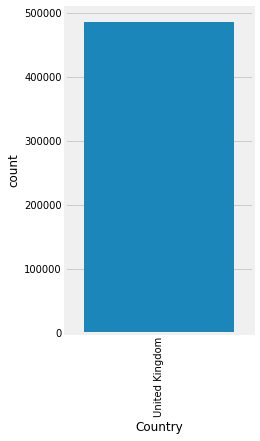

In [26]:
plt.figure(figsize=(3,6))
sns.countplot(df[df['Country'] == 'United Kingdom']['Country'])
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36]), <a list of 37 Text xticklabel objects>)

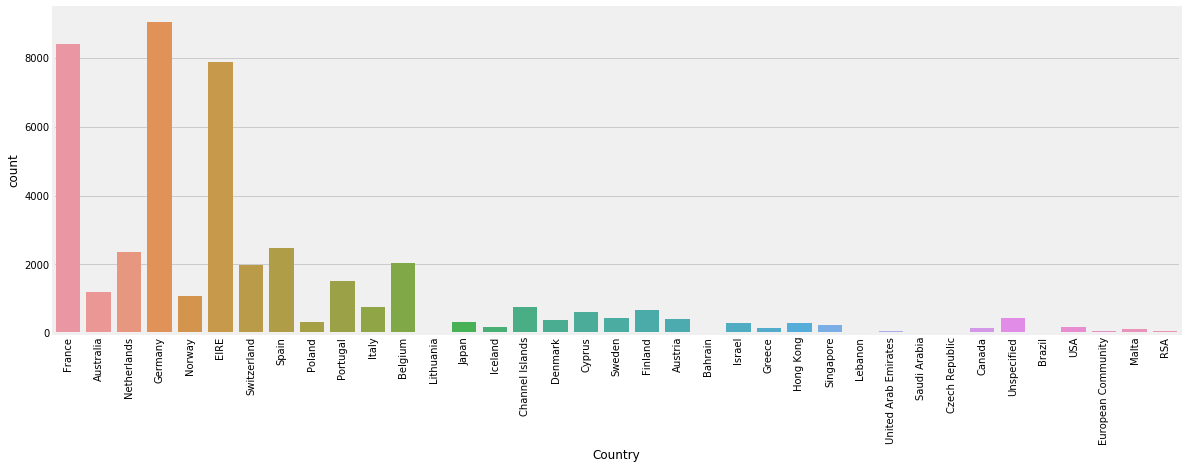

In [27]:
plt.figure(figsize=(18,6))
sns.countplot(df[df['Country'] != 'United Kingdom']['Country'])
plt.xticks(rotation=90)

In [28]:
uk_count = df[df['Country'] == 'United Kingdom']['Country'].count()
all_count = df['Country'].count()
uk_perc = uk_count/all_count
print(str('{0:.2f}%').format(uk_perc*100))

91.51%


From above plots and calculations we can see that vast majority of sales were made in UK and just 8.49% went abroad. 

We can say our dataset is skewed to the UK side

### Detecting outliers

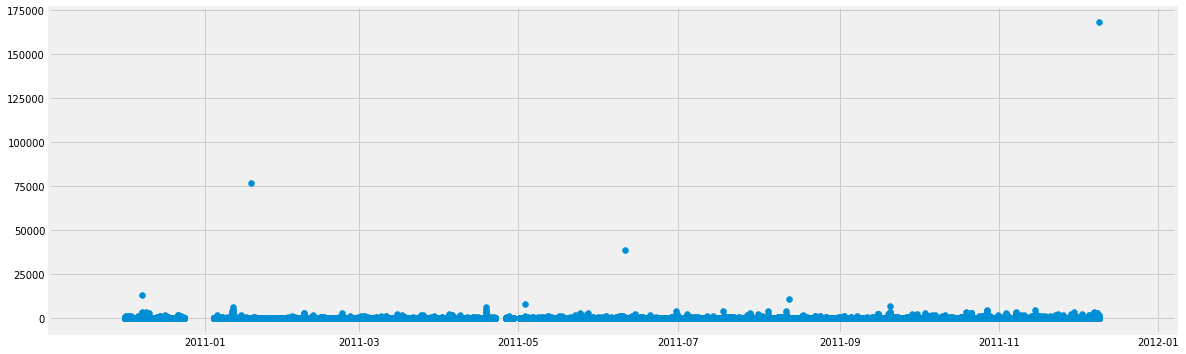

In [29]:
plt.figure(figsize=(18,6))
plt.scatter(x=df.index, y=df['Sales'])

Let's remove obvious outliers

(array([734138., 734197., 734258., 734319., 734381., 734442., 734503.]),
 <a list of 7 Text xticklabel objects>)

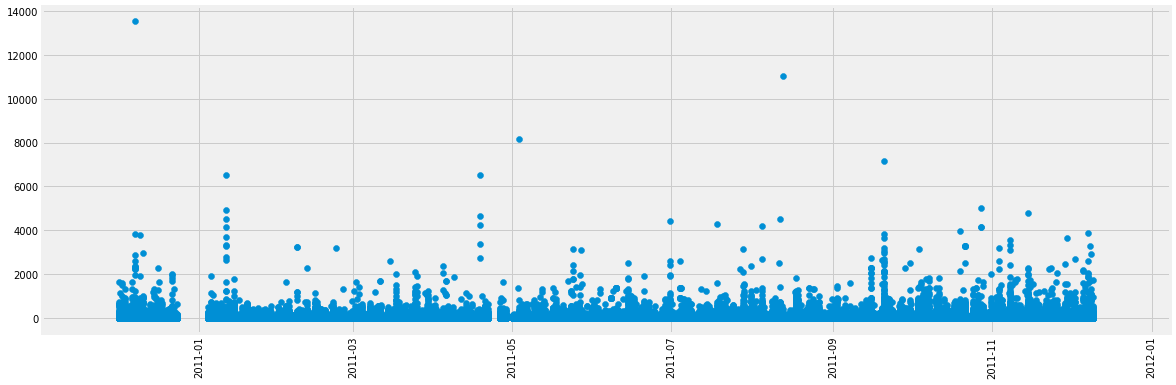

In [30]:
df = df[df['Sales'] < 25000]
plt.figure(figsize=(18,6))
plt.scatter(x=df.index, y=df['Sales'])
plt.xticks(rotation=90)

After removing obvious outliers we still see some values that are out of normal distribution. 

To understand better the distribution of our data let's check out different percentiles of our numeric features

In [31]:
df.quantile([0.5, 0.95,0.99, 0.999])

,Quantity,UnitPrice,Sales
0.500,3.0,2.08,9.90
0.950,30.0,9.95,59.70
0.990,100.0,16.98,183.60
0.999,446.4,165.00,833.79


We can see that if we remove top 2% of our data points we will get rid of absolute outliers
and will have more balaced dataset.

(array([734077., 734138., 734197., 734258., 734319., 734381., 734442.,
        734503.]), <a list of 8 Text xticklabel objects>)

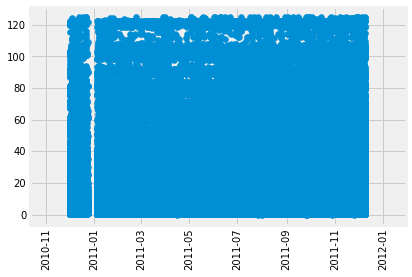

In [32]:
df_quantile = df[df['Sales'] < 125]
plt.scatter(x=df_quantile.index, y=df_quantile['Sales'])
plt.xticks(rotation=90)

In [33]:
df_quantile.describe()

,Quantity,UnitPrice,Sales
count,519958.000000,519958.000000,519958.000000
mean,7.850934,3.286582,13.850263
std,15.303867,3.949021,16.330954
min,1.000000,0.001000,0.001000
25%,1.000000,1.250000,3.750000
50%,3.000000,2.080000,9.840000
75%,10.000000,4.130000,17.220000
max,1600.000000,124.870000,124.950000


Looks like our data is almost ready for modelling. We performed a clean up, we removed outliers that were disturbing the balance of our dataset, 
we removed invalid records - now our data looks much better! and it doesn't lose it's value.

### Visually checking distribution of numeric features

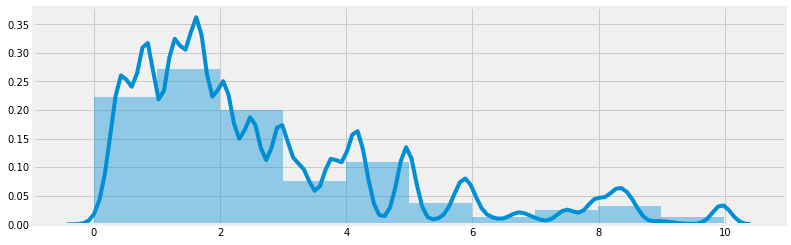

In [34]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['UnitPrice'] < 10]['UnitPrice'].values, kde=True, bins=10)

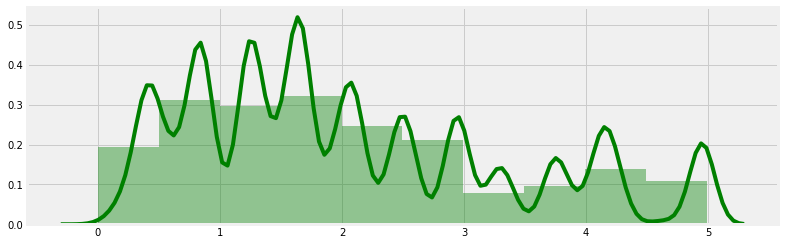

In [35]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['UnitPrice'] < 5]['UnitPrice'].values, kde=True, bins=10, color='green')

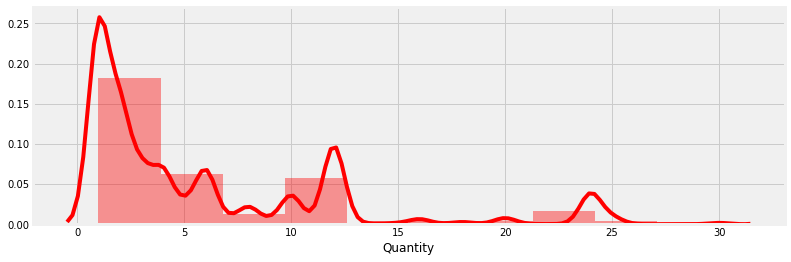

In [36]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['Quantity'] <= 30]['Quantity'], kde=True, bins=10, color='red')

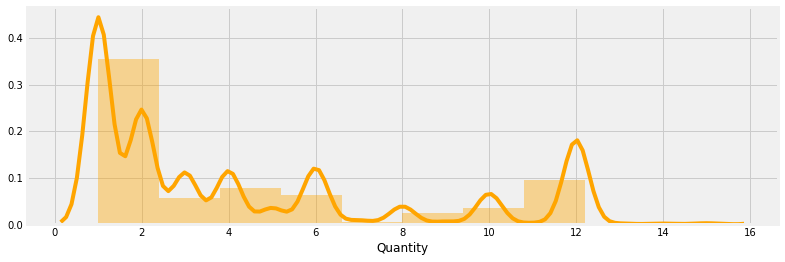

In [37]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['Quantity'] <= 15]['Quantity'], kde=True, bins=10, color='orange')

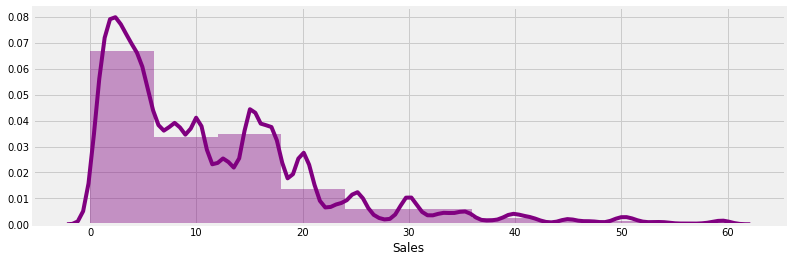

In [38]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['Sales'] < 60]['Sales'], kde=True, bins=10, color='purple')

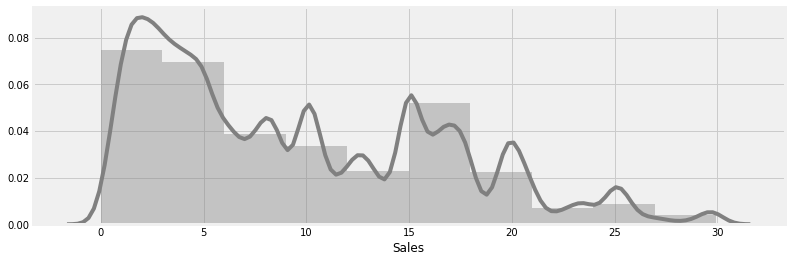

In [39]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['Sales'] < 30]['Sales'], kde=True, bins=10, color='grey')

### Analysing sales over time

In [40]:
df_ts = df[['Sales']]
df_ts.head()

,Sales
InvoiceDate,
2010-12-01 08:26:00,15.30
2010-12-01 08:26:00,20.34
2010-12-01 08:26:00,22.00
2010-12-01 08:26:00,20.34
2010-12-01 08:26:00,20.34


As we can see every invoice has it's own timestamp (definitely based on time the order was made). 
We can resample time data by, for example weeks, and try see if there is any patterns in our sales.

<Figure size 1296x432 with 0 Axes>

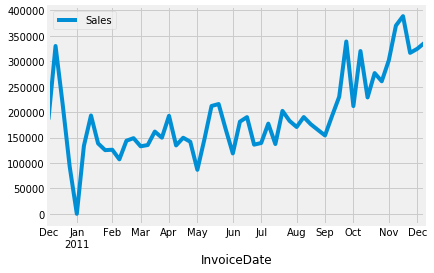

In [41]:
plt.figure(figsize=(18,6))
df_resample = df_ts.resample('W').sum()
df_resample.plot()

That week with 0 sales in January looks suspicious, let's check it closer

In [42]:
df_resample['12-2010':'01-2011']

,Sales
InvoiceDate,
2010-12-05,185427.83
2010-12-12,329936.81
2010-12-19,216012.20
2010-12-26,92369.30
2011-01-02,0.00
2011-01-09,133658.19
2011-01-16,193362.04
2011-01-23,138349.58
2011-01-30,125170.79


Now it makes sense - possibly, during the New Year holidays period the store was closed and didn't process orders,
that's why they didn't make any sales.

#### Preparing data for modeling and feature creation

In [43]:
df_clean = df[df['UnitPrice'] < 15]
df_clean.describe()

,Quantity,UnitPrice,Sales
count,520393.000000,520393.000000,520393.000000
mean,10.409364,2.978735,18.669870
std,38.123726,2.669829,64.710055
min,1.000000,0.001000,0.001000
25%,1.000000,1.250000,3.750000
50%,4.000000,2.080000,9.840000
75%,12.000000,4.130000,17.400000
max,4800.000000,14.960000,7144.720000


Quantity per invoice feature

In [44]:
df_clean.shape

(520393, 7)

In [45]:
df_join = df_clean.groupby('InvoiceNo')[['Quantity']].sum()

In [46]:
df_join.head()

,Quantity
InvoiceNo,
536365,40
536366,12
536367,83
536368,15
536369,3


In [47]:
df_join = df_join.reset_index()
df_join.head()

,InvoiceNo,Quantity
0,536365,40
1,536366,12
2,536367,83
3,536368,15
4,536369,3


In [48]:
df_join.shape

(19754, 2)

In [49]:
df_clean['InvoiceDate'] = df_clean.index
df_clean = df_clean.merge(df_join, how='left', on='InvoiceNo')
df_clean = df_clean.rename(columns={'Quantity_x' : 'Quantity', 'Quantity_y' : 'QuantityInv'})
df_clean.tail(15)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,Sales,InvoiceDate,QuantityInv
520378,581587,22631,CIRCUS PARADE LUNCH BOX,12,1.95,France,23.40,2011-12-09 12:50:00,105
520379,581587,22556,PLASTERS IN TIN CIRCUS PARADE,12,1.65,France,19.80,2011-12-09 12:50:00,105
520380,581587,22555,PLASTERS IN TIN STRONGMAN,12,1.65,France,19.80,2011-12-09 12:50:00,105
520381,581587,22728,ALARM CLOCK BAKELIKE PINK,4,3.75,France,15.00,2011-12-09 12:50:00,105
520382,581587,22727,ALARM CLOCK BAKELIKE RED,4,3.75,France,15.00,2011-12-09 12:50:00,105
520383,581587,22726,ALARM CLOCK BAKELIKE GREEN,4,3.75,France,15.00,2011-12-09 12:50:00,105
520384,581587,22730,ALARM CLOCK BAKELIKE IVORY,4,3.75,France,15.00,2011-12-09 12:50:00,105
520385,581587,22367,CHILDRENS APRON SPACEBOY DESIGN,8,1.95,France,15.60,2011-12-09 12:50:00,105
520386,581587,22629,SPACEBOY LUNCH BOX,12,1.95,France,23.40,2011-12-09 12:50:00,105
520387,581587,23256,CHILDRENS CUTLERY SPACEBOY,4,4.15,France,16.60,2011-12-09 12:50:00,105


In [50]:
df_clean.shape

(520393, 9)

In [51]:
df_clean.describe()

,Quantity,UnitPrice,Sales,QuantityInv
count,520393.000000,520393.000000,520393.000000,520393.000000
mean,10.409364,2.978735,18.669870,533.328732
std,38.123726,2.669829,64.710055,890.339855
min,1.000000,0.001000,0.001000,1.000000
25%,1.000000,1.250000,3.750000,152.000000
50%,4.000000,2.080000,9.840000,300.000000
75%,12.000000,4.130000,17.400000,567.000000
max,4800.000000,14.960000,7144.720000,15049.000000


In [52]:
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

In [53]:
df_clean.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
UnitPrice             float64
Country                object
Sales                 float64
InvoiceDate    datetime64[ns]
QuantityInv             int64
dtype: object

Bucketizing Quantity and UnitPrice features

In [54]:
bins_q = pd.IntervalIndex.from_tuples([(0, 2), (2, 5), (5, 8), (8, 11), (11, 14), (15, 5000)])
df_clean['QuantityRange'] = pd.cut(df_clean['Quantity'], bins=bins_q)
bins_p = pd.IntervalIndex.from_tuples([(0, 1), (1, 2), (2, 3), (3, 4), (4, 20)])
df_clean['PriceRange'] = pd.cut(df_clean['UnitPrice'], bins=bins_p)
df_clean.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,Sales,InvoiceDate,QuantityInv,QuantityRange,PriceRange
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom,15.30,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]"
1,536365,71053,WHITE METAL LANTERN,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]"
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom,22.00,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]"
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]"
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]"


Extracting and bucketizing date

We have noticed that depends on a season gifts sell differently: pick of sales is in the Q4,
then it drastically drops in Q1 of the next year and continues to grow till its new pick in Q4 again.
From this observation we can create another feature that could improve our model.

In [55]:
df_clean['Month'] = df_clean['InvoiceDate'].dt.month
df_clean.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,Sales,InvoiceDate,QuantityInv,QuantityRange,PriceRange,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom,15.30,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]",12
1,536365,71053,WHITE METAL LANTERN,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom,22.00,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]",12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12


In [56]:
bins_d = pd.IntervalIndex.from_tuples([(0,3),(3,6),(6,9),(9,12)])
df_clean['DateRange'] = pd.cut(df_clean['Month'], bins=bins_d, labels=['q1','q2','q3','q4'])
df_clean.tail()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,Sales,InvoiceDate,QuantityInv,QuantityRange,PriceRange,Month,DateRange
520388,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85,France,10.20,2011-12-09 12:50:00,105,"(11, 14]","(0, 1]",12,"(9, 12]"
520389,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2.10,France,12.60,2011-12-09 12:50:00,105,"(5, 8]","(2, 3]",12,"(9, 12]"
520390,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,4.15,France,16.60,2011-12-09 12:50:00,105,"(2, 5]","(4, 20]",12,"(9, 12]"
520391,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,4.15,France,16.60,2011-12-09 12:50:00,105,"(2, 5]","(4, 20]",12,"(9, 12]"
520392,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,4.95,France,14.85,2011-12-09 12:50:00,105,"(2, 5]","(4, 20]",12,"(9, 12]"


### Building a model

Splitting data into UK and non-UK

In [57]:
df_uk = df_clean[df_clean['Country'] == 'United Kingdom']
df_abroad = df_clean[df_clean['Country'] != 'United Kingdom']

In [58]:
df_uk.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,Sales,InvoiceDate,QuantityInv,QuantityRange,PriceRange,Month,DateRange
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom,15.30,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]",12,"(9, 12]"
1,536365,71053,WHITE METAL LANTERN,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12,"(9, 12]"
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom,22.00,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]",12,"(9, 12]"
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12,"(9, 12]"
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12,"(9, 12]"


Extracting features and creating dummy variables

In [59]:
df_uk_model = df_uk[['Sales', 'QuantityInv', 'QuantityRange', 'PriceRange', 'DateRange']]
df_uk_model.head()

,Sales,QuantityInv,QuantityRange,PriceRange,DateRange
0,15.30,40,"(5, 8]","(2, 3]","(9, 12]"
1,20.34,40,"(5, 8]","(3, 4]","(9, 12]"
2,22.00,40,"(5, 8]","(2, 3]","(9, 12]"
3,20.34,40,"(5, 8]","(3, 4]","(9, 12]"
4,20.34,40,"(5, 8]","(3, 4]","(9, 12]"


In [60]:
df_data = df_uk_model.copy()
df_data = pd.get_dummies(df_data, columns=['QuantityRange'], prefix='qr')
df_data = pd.get_dummies(df_data, columns=['PriceRange'], prefix='pr')
df_data = pd.get_dummies(df_data, columns=['DateRange'], prefix='dr')
df_data.head()

,Sales,QuantityInv,"qr_(0, 2]","qr_(2, 5]","qr_(5, 8]","qr_(8, 11]","qr_(11, 14]","qr_(15, 5000]","pr_(0, 1]","pr_(1, 2]","pr_(2, 3]","pr_(3, 4]","pr_(4, 20]","dr_(0, 3]","dr_(3, 6]","dr_(6, 9]","dr_(9, 12]"
0,15.30,40,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
1,20.34,40,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
2,22.00,40,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
3,20.34,40,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
4,20.34,40,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1


### Scaling

As the majority of our features are in 0-1 range it would make sense to scale "QuantityInv" feature too. 
In general, scaling features is normally a good idea.

In [61]:
from sklearn.preprocessing import scale
df_data['QuantityInv'] = scale(df_data['QuantityInv'])

Train-Test Split

In [62]:
y = df_data['Sales']
X = df_data.drop(columns=['Sales'])

In [63]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

### Testing and validating different models

Here we use GridSearch and CrossValidation to test three types of regressors:
Linear, DecisionTree and RandomForest.
This can take a while...

In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [72]:
# Linear Regression
fit_intercepts = [True, False]
param_grid_linear = dict(fit_intercept=fit_intercepts)
linear_model = LinearRegression()
param_grid_linear

{'fit_intercept': [True, False]}

Fit intercept: specifies whether the y intercept of the model should be calculated or set to zero.
If false, intercept for regression line will be 0.
If true, model will calculate the intercept

In [66]:
cv = 5

In [67]:
score_dict = {}
params_dict = {}
mae_dict = {}
mse_dict = {}
r2_dict = {}
best_est_dict = {}

In [68]:
regressor = GridSearchCV(linear_model, param_grid_linear, cv=cv, n_jobs=-1)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [69]:
y_pred

array([ 2.73510742, 19.48999023,  8.41992188, ..., 25.58178711,
       -5.40869141, 59.86376953])

In [70]:
# Print the tuned parameters and score
print(" === Start report for regressor {} ===".format(linear_model))
score_dict[linear_model] = regressor.best_score_
print("Tuned Parameters: {}".format(regressor.best_params_)) 
params_dict = regressor.best_params_
print("Best score is {}".format(regressor.best_score_))

 === Start report for regressor LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) ===
Tuned Parameters: {'fit_intercept': False}
Best score is 0.1742407535591111


In [71]:
# Compute metrics
mae_dict[linear_model] = mean_absolute_error(y_test, y_pred)
print("MAE for {}".format(linear_model))
print(mean_absolute_error(y_test, y_pred))
mse_dict[linear_model] = mean_squared_error(y_test, y_pred)
print("MSE for {}".format(linear_model))
print(mean_squared_error(y_test, y_pred))
r2_dict[linear_model] = r2_score(y_test, y_pred)
print("R2 score for {}".format(linear_model))
print(r2_score(y_test, y_pred))
print(" === End of report for regressor {} === \n".format(linear_model))

MAE for LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
15.080666630359298
MSE for LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
3918.969280064821
R2 score for LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
0.15628183886510938
 === End of report for regressor LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) === 

